### Study of the bursting dynamcis of the nodes

In [1]:
import sys
sys.path.insert(1, '/home/vinicius/storage1/projects/GrayData-Analysis')
from   GDa.session           import session_info, session
from   xfrites.conn.conn_coh import _tf_decomp, _create_kernel, _smooth_spectra

import numpy             as np
import xarray            as xr
import matplotlib.pyplot as plt
import h5py
import scipy
from   tqdm              import tqdm

#### Load session and filter for ODRT trials with correct response

In [2]:
stages      = ['baseline', 'cue', 'delay', 'match']
band_names  = [r'$\theta$', r'$\alpha$', r'$\beta$', r'low-$\gamma$ ', r'high-$\gamma$' ]

In [3]:
# Instantiate class
s = session(raw_path = '../GrayLab/', monkey = 'lucy', date = '150128', session = 1,
            slvr_msmod = False, align_to = 'cue', evt_dt = [-0.65, 3.00])

# Read data from .mat files
s.read_from_mat()
# Filtering by trials
s.filter_trials([1],[1])

#### Compute spectra for the data

In [4]:
# Smoothing windows
sm_times  = 500
sm_freqs  = 1
sm_kernel = "square"

# Defining parameters
delta = 10       # Downsampling factor
mode  = 'morlet' # ("morlet", "mt_1", "mt_2")
#  mode  = 'multitaper' # ("morlet", "mt_1", "mt_2")
foi   = np.array([
        [0.1, 6.],
        [6., 14.],
        [14., 26.],
        [26., 42.],
        [42., 80.]
            ])

n_freqs = 50
freqs   = np.linspace(foi[0,0], foi[-1,1], n_freqs, endpoint=True)
n_cycles     = freqs/2

In [5]:
# Wavelet transform
w = _tf_decomp(s.data, s.data.attrs["fsample"], freqs, mode=mode, n_cycles=n_cycles,
           decim=delta, n_jobs=-1)

# kernel smoothing definition
kernel = _create_kernel(sm_times//delta, sm_freqs, kernel=sm_kernel)

# auto spectra (faster that w * w.conj())
s_auto = w.real ** 2 + w.imag ** 2
# smooth the auto spectra
s_auto = _smooth_spectra(s_auto, kernel)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:   16.9s remaining:   24.5s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:   21.7s remaining:   13.7s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:   26.4s remaining:    5.9s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:   30.7s finished


In [6]:
# Average over bands of interest
need_foi = isinstance(foi, np.ndarray) and foi.shape[1] == 2
if need_foi:
    _f = xr.DataArray(np.arange(len(freqs)), dims=('freqs',),
                      coords=(freqs,))
    foi_s = _f.sel(freqs=foi[:, 0], method='nearest').data
    foi_e = _f.sel(freqs=foi[:, 1], method='nearest').data
    foi_idx = np.c_[foi_s, foi_e]
    f_vec = freqs[foi_idx].mean(1)

In [7]:
if need_foi:
    s_auto_f = []
    for f_s, f_e in foi_idx:
        s_auto_f += [s_auto[:, :,  f_s:f_e, :].mean(-2, keepdims=True)]
    s_auto = np.concatenate(s_auto_f, axis=-2)

In [8]:
s_auto = xr.DataArray(s_auto, dims=("trials", "roi", "freqs", "times"),
                      coords={"trials": s.data.trials.values,
                              "roi":s.data.roi.values,
                              "freqs": f_vec,
                              "times": s.data.time.values[::delta]}
                     )

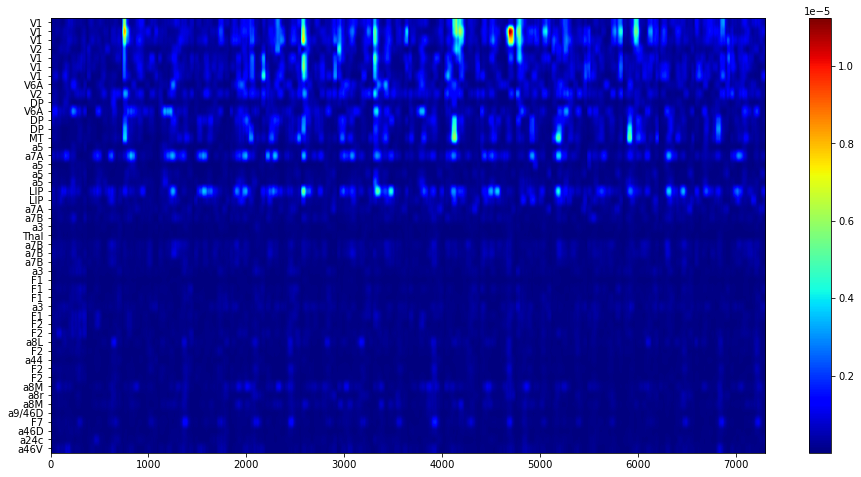

In [9]:
plt.figure(figsize=(16,8))
plt.imshow(s_auto.isel(freqs=0,trials=slice(0,20)).stack(observations=("trials","times")).values, aspect="auto", cmap="jet",origin="lower", interpolation=None)
plt.yticks(range(49), s_auto.roi.values)
plt.colorbar()

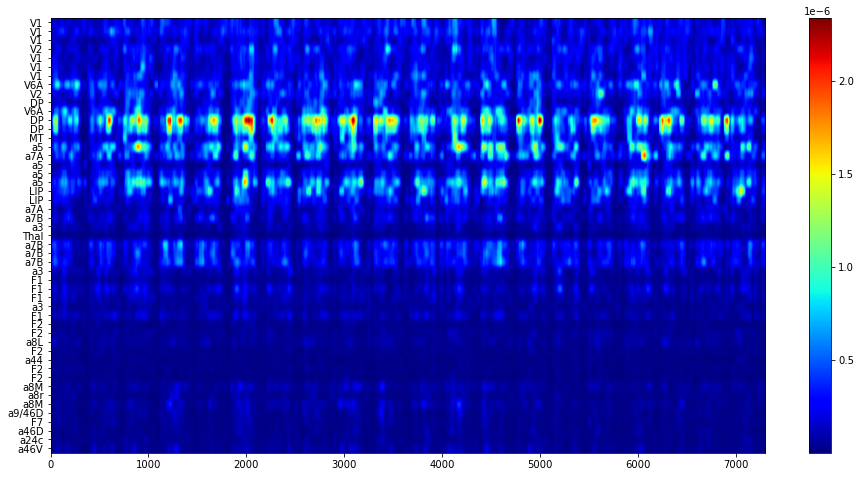

In [10]:
plt.figure(figsize=(16,8))
plt.imshow(s_auto.isel(freqs=1,trials=slice(0,20)).stack(observations=("trials","times")).values, aspect="auto", cmap="jet",origin="lower", interpolation=None)
plt.yticks(range(49), s_auto.roi.values)
plt.colorbar()

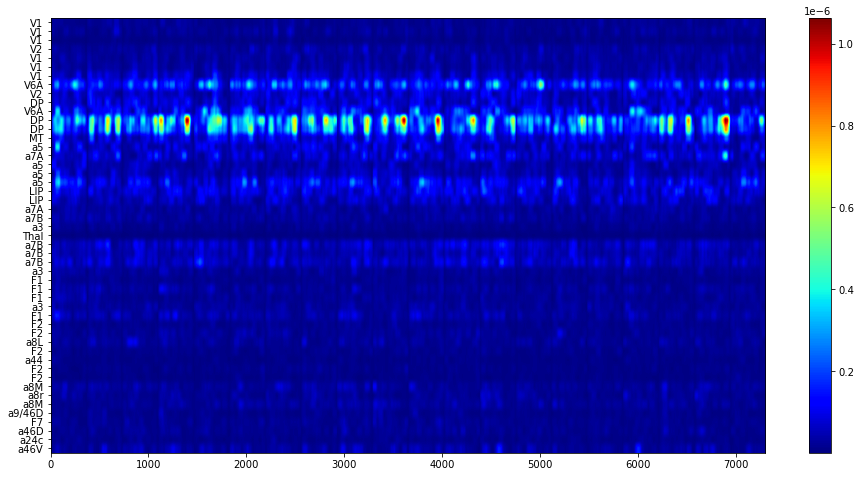

In [11]:
plt.figure(figsize=(16,8))
plt.imshow(s_auto.isel(freqs=2,trials=slice(0,20)).stack(observations=("trials","times")).values, aspect="auto", cmap="jet",origin="lower", interpolation=None)
plt.yticks(range(49), s_auto.roi.values)
plt.colorbar()

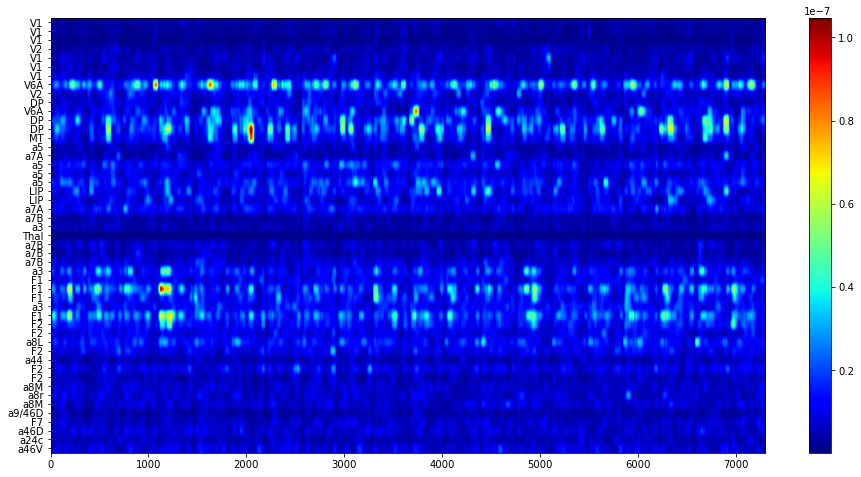

In [12]:
plt.figure(figsize=(16,8))
plt.imshow(s_auto.isel(freqs=3,trials=slice(0,20)).stack(observations=("trials","times")).values, aspect="auto", cmap="jet",origin="lower", interpolation=None)
plt.yticks(range(49), s_auto.roi.values)
plt.colorbar()

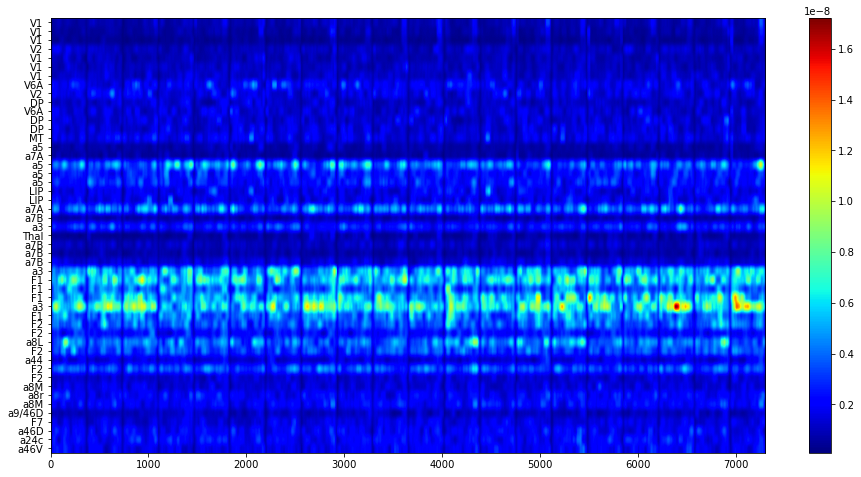

In [16]:
plt.figure(figsize=(16,8))
plt.imshow(s_auto.isel(freqs=4,trials=slice(0,20)).stack(observations=("trials","times")).values, aspect="auto", cmap="jet",origin="lower", interpolation=None)
plt.yticks(range(49), s_auto.roi.values)
plt.colorbar()